- This file is used to analyizing Arxiv data and so transformation and visualization for the data before classification

In [1]:
import sys
import pyspark
import time
from pyspark.sql import SparkSession 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from delta import DeltaTable, configure_spark_with_delta_pip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
delta_table_path = "hdfs:///Dat500_Group09/spark_result/final_result/arxiv_meta"

# Set the configuration properties for Delta tables
builder = pyspark.sql.SparkSession.builder.appName("Arxiv_analyzing_baseline") \
    .master('yarn') \
    .config("spark.sql.shuffle.partitions", 24)\
    .config('spark.executor.instances', 12)\
    .config('spark.driver.memory', "8g")\
    .config("spark.executor.memory", "1g")\
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")\
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    
    
spark = configure_spark_with_delta_pip(builder).getOrCreate()


:: loading settings :: url = jar:file:/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f95ee3e2-7561-4599-a65d-57eac18e3223;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.3.0 in central
	found io.delta#delta-storage;2.3.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
:: resolution report :: resolve 247ms :: artifacts dl 11ms
	:: modules in use:
	io.delta#delta-core_2.12;2.3.0 from central in [default]
	io.delta#delta-storage;2.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   

23/04/26 01:32:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/26 01:32:05 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
23/04/26 01:32:14 WARN Client: Same path resource file:///home/ubuntu/.ivy2/jars/io.delta_delta-core_2.12-2.3.0.jar added multiple times to distributed cache.
23/04/26 01:32:14 WARN Client: Same path resource file:///home/ubuntu/.ivy2/jars/io.delta_delta-storage-2.3.0.jar added multiple times to distributed cache.
23/04/26 01:32:14 WARN Client: Same path resource file:///home/ubuntu/.ivy2/jars/org.antlr_antlr4-runtime-4.8.jar added multiple times to distributed cache.


In [3]:
# print spark configuration values
print("Spark configuration values")
print("="*100)
from pyspark import SparkConf
#spark.set
print("No of shuffle.partitions",  spark.conf.get("spark.sql.shuffle.partitions"))
print("spark.executor.memory",  spark.conf.get("spark.executor.memory"))
print("spark.driver.memory",  spark.conf.get("spark.driver.memory"))


print("="*100)
conf = SparkConf()
config_map = conf.getAll()
for key, value in config_map:
    print(f"{key}: {value}")

Spark configuration values
No of shuffle.partitions 24
spark.executor.memory 1g
spark.driver.memory 8g
spark.yarn.dist.jars: file:///home/ubuntu/.ivy2/jars/io.delta_delta-core_2.12-2.3.0.jar,file:///home/ubuntu/.ivy2/jars/io.delta_delta-storage-2.3.0.jar,file:///home/ubuntu/.ivy2/jars/org.antlr_antlr4-runtime-4.8.jar
spark.sql.shuffle.partitions: 24
spark.submit.pyFiles: /home/ubuntu/.ivy2/jars/io.delta_delta-core_2.12-2.3.0.jar,/home/ubuntu/.ivy2/jars/io.delta_delta-storage-2.3.0.jar,/home/ubuntu/.ivy2/jars/org.antlr_antlr4-runtime-4.8.jar
spark.app.submitTime: 1682472722561
spark.app.name: Arxiv_analyzing_baseline
spark.executor.instances: 12
spark.jars.packages: io.delta:delta-core_2.12:2.3.0
spark.master: yarn
spark.ui.proxyBase: /proxy/application_1679580022279_0232
spark.sql.extensions: io.delta.sql.DeltaSparkSessionExtension
spark.executor.memory: 1g
spark.driver.memory: 8g
spark.yarn.isPython: true
spark.submit.deployMode: client
spark.yarn.dist.pyFiles: file:///home/ubuntu/.iv

In [4]:
   
delta_preprocessing_file = "hdfs:///Dat500_Group09/spark_result/preprocessing"

# read preprocessing file which has the data after cleaning and preprocessing
arxiv_df = spark.read.format("delta").load(delta_preprocessing_file)

arxiv_df.show(3)

23/04/26 01:32:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+
|        id|                text|               title|            abstract|authers_num|article_date|main_category|          main_topic|
+----------+--------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+
|1501.03263|Emission-Line Flu...|Emission-Line Flu...| We present long ...|          3|  2015-01-01|      Physics|Astrophysics of G...|
|1501.03264|Spectral Analysis...|Spectral Analysis...| In this paper we...|          2|  2015-01-01|  Mathematics|         Probability|
|1501.03265|Quantum transitio...|Quantum transitio...| We investigate q...|          4|  2015-01-01|      Physics|Statistical Mecha...|
+----------+--------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+
only showing top 3 rows



1- Check duplicate values, null values.

In [15]:
# Check null values for all columns in the dataframe by using 'isNull()' method 
print("Check null values for all columns")
for col_Name in arxiv_df.columns:
    print(col_Name, arxiv_df.filter(col(col_Name).isNull()).count())

# Removed duplicate id and return the dataframe after removeing the duplicate, in our data we dont have any duplicate in id
arxiv_df = arxiv_df.dropDuplicates(['id'])

Check null values for all columns


id 0


text 0


title 0


abstract 0


authers_num 0


article_date 0


main_category 0


main_topic 0


#### Analyzing arxiv data frame
- finding most frequent topics count used in arxiv data

In [5]:
#finding most frequent topics count used in arxiv data
count_topics = arxiv_df.groupBy("main_topic").agg(count("*").alias("count")).orderBy("count", ascending=False)


In [6]:
print('The most frequant Topics in the Arxiv data')
count_topics.show(10, False)

The most frequant Topics in the Arxiv data


+----------------------------------------+------+
|main_topic                              |count |
+----------------------------------------+------+
|High Energy Physics - Phenomenology     |125021|
|High Energy Physics - Theory            |99702 |
|Quantum Physics                         |96082 |
|Machine Learning                        |75362 |
|Computer Vision and Pattern Recognition |67993 |
|Mesoscale and Nanoscale Physics         |58164 |
|General Relativity and Quantum Cosmology|57811 |
|Materials Science                       |53672 |
|Strongly Correlated Electrons           |44248 |
|Analysis of PDEs                        |42283 |
+----------------------------------------+------+
only showing top 10 rows



- Display the count for each main category in the arxiv data

In [7]:

category_df = arxiv_df.groupBy("main_category").count()
pd_category_df = category_df.toPandas()
# Sort the categories by count
pd_category_sort = pd_category_df.sort_values(by='count', ascending=False)


In [8]:
pd_category_sort.head(10)

,main_category,count
0,Physics,1129859
3,Mathematics,446127
5,Computer Science,397171
7,Statistics,41542
4,Electrical Engineering,35336
6,Quantitative Biology,25065
1,Quantitative Finance,9850
2,Economics,5103


In [9]:
# save the main categories into a list , we will used it in visualization
main_categorylist = list(pd_category_sort["main_category"])

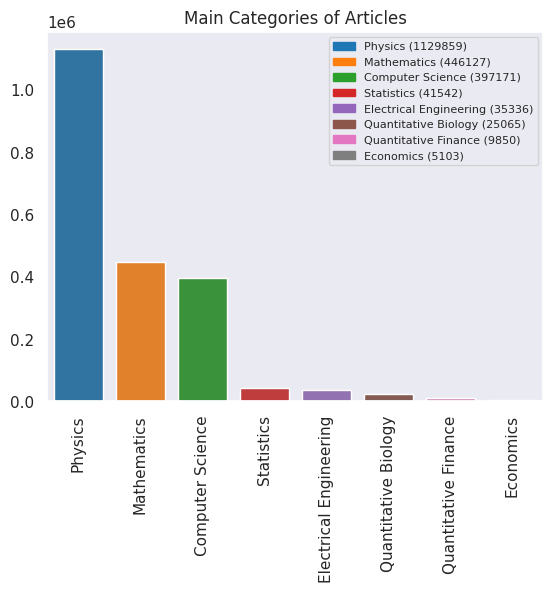

In [10]:
#Color palette : pastel, Set2, Dark2, Paired,tab10
sns.set(style="dark")

colors = sns.color_palette('tab10', len(pd_category_sort))
ax = sns.barplot(x="main_category", y="count", data=pd_category_sort, palette=colors)

plt.xticks(rotation=90)
# create a custom legend with colored labels
legend_labels = [f"{category} ({count})" for category, count in zip(pd_category_sort['main_category'], pd_category_sort['count'])]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(handles=legend_handles, labels=legend_labels, fontsize=8)
ax.set_title('Main Categories of Articles')
ax.set_xlabel(None)
ax.set_ylabel(None)

plt.show()


- Display the trend for the articles, How many articles is published over years depending on thier main_category

In [11]:

counts_by_category_year = arxiv_df.groupBy(year("article_date").alias("year"), "main_category").count().orderBy("year", "count", ascending=[1, 0])
counts_by_category_year.show(3)

+----+-------------+-----+
|year|main_category|count|
+----+-------------+-----+
|1991|      Physics|  306|
|1992|      Physics| 2611|
|1992|  Mathematics|  277|
+----+-------------+-----+
only showing top 3 rows



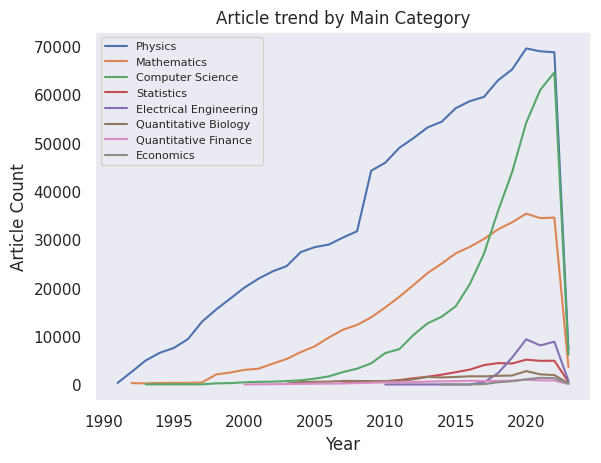

In [12]:
# create a line chart for each main category
for category in main_categorylist:
    # filter the dataframe to get data for the current category
    data = counts_by_category_year.filter(counts_by_category_year["main_category"] == category).toPandas()

    sns.lineplot(data=data, x="year", y="count", label=category)
   


plt.title("Article trend by Main Category")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.legend(fontsize=8)

plt.show()

- Display the author's average and maximum author numbers for each category, and how the authors number changes over the years

In [25]:
# group by main category, aggregate max authors, avg auther no
auther_arxiv_df = arxiv_df.groupBy("main_category", year("article_date").alias("article_year")) \
  .agg(round(avg("authers_num"),0).alias("avg_authors"),     
       max("authers_num").alias("max_authors")).orderBy("main_category", "article_year", "avg_authors")

In [31]:
auther_arxiv_df.filter(auther_arxiv_df.main_category == "Computer Science").show(10)

+----------------+------------+-----------+-----------+
|   main_category|article_year|avg_authors|max_authors|
+----------------+------------+-----------+-----------+
|Computer Science|        1993|        1.0|          3|
|Computer Science|        1994|        2.0|          3|
|Computer Science|        1995|        2.0|          5|
|Computer Science|        1996|        2.0|          4|
|Computer Science|        1997|        2.0|          5|
|Computer Science|        1998|        3.0|         16|
|Computer Science|        1999|        3.0|         23|
|Computer Science|        2000|        2.0|         10|
|Computer Science|        2001|        2.0|         15|
|Computer Science|        2002|        2.0|         15|
+----------------+------------+-----------+-----------+
only showing top 10 rows



- Display how Maximum authors for Computer science changes over the years

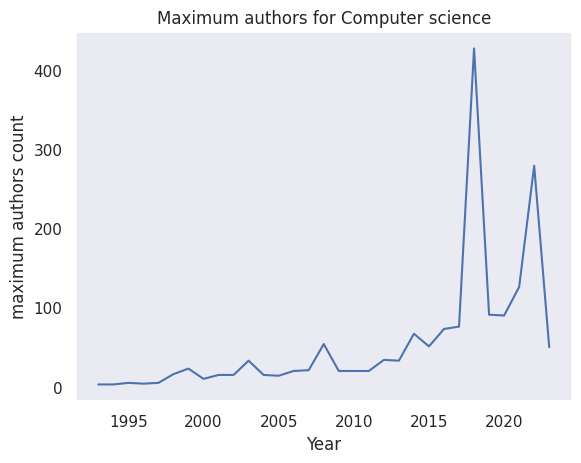

In [32]:

category = 'Computer Science'
group = 'max_authors'

#category computer science
data = auther_arxiv_df.filter(auther_arxiv_df["main_category"] == category).toPandas()

# extract the year and group columns
years = data['article_year']
group_counts = data[group]

# create the bar chart
#plt.bar(years, group_counts)
sns.lineplot(data=data, x=years, y=group_counts)

# set the chart title and axes labels
plt.title(f'Maximum authors for Computer science')
plt.xlabel('Year')
plt.ylabel(f'maximum authors count')

# display the chart
plt.show()


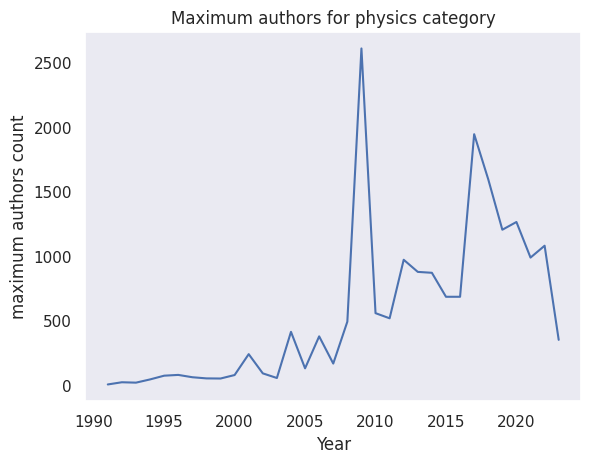

In [33]:
# set the category and group to plot
category = 'Physics'
group = 'max_authors'

# filter the dataframe to get data for the current category physics
data = auther_arxiv_df.filter(auther_arxiv_df["main_category"] == category).toPandas()

# extract the year and group columns
years = data['article_year']
group_counts = data[group]
table_data = data[['article_year', group]]
# create the bar chart
#plt.bar(years, group_counts)
sns.lineplot(data=data, x=years, y=group_counts)

# set the chart title and axes labels
plt.title(f'Maximum authors for physics category')
plt.xlabel('Year')
plt.ylabel(f'maximum authors count')

# display the chart
plt.show()


- Display the maximum authers_num grouped by main_category

In [21]:

Max_auther_df = arxiv_df.groupBy("main_category") \
  .agg(round(avg("authers_num"),0).alias("avg_authors"),     
       max("authers_num").alias("max_authors"))


In [22]:
#Max_auther_df.show(8)
df_pandas = Max_auther_df.toPandas()

# Sort the categories by max_authors
Max_auther_sort = df_pandas.sort_values(by='max_authors', ascending=False)

Max_auther_sort.head(10)


,main_category,avg_authors,max_authors
7,Physics,5.0,2611
4,Computer Science,4.0,427
5,Quantitative Biology,4.0,347
3,Electrical Engineering,4.0,170
6,Statistics,3.0,122
2,Mathematics,2.0,60
1,Economics,2.0,40
0,Quantitative Finance,2.0,20


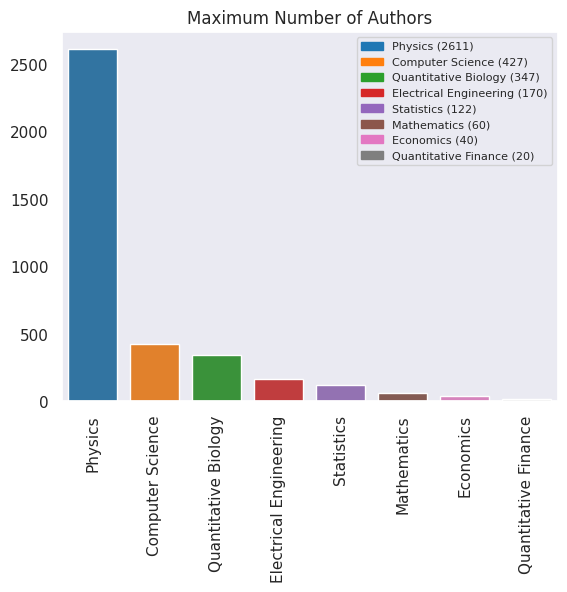

In [23]:
# print 
sns.set(style="dark")

colors = sns.color_palette('tab10', len(Max_auther_sort))
ax = sns.barplot(x="main_category", y="max_authors", data=Max_auther_sort, palette=colors)

plt.xticks(rotation=90)
# create a custom legend with colored labels

legend_labels = [f"{category} ({max_authors})" for category, max_authors in zip(Max_auther_sort['main_category'], Max_auther_sort['max_authors'])]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(handles=legend_handles, labels=legend_labels, fontsize=8)
ax.set_title('Maximum Number of Authors')
ax.set_xlabel(None)
ax.set_ylabel(None)

plt.show()